# Collectl Log Analysis

## Functionalities
- Plot CPU utilization graphs.
- Plot memory utilization graphs.
- Plot disk I/O utilization graphs.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    collectl.tar.gz
  ...
  [node-n]/
    collectl.tar.gz
```
A tarball `collectl.tar.gz` contains log files. The log file extension identifies the type of resource monitored:
- `.cpu.gz`: CPU monitoring log file.
- `.numa.gz`: memory monitoring log file.
- `.dsk.gz`: disk I/O monitoring log file.

## Notebook Configuration

In [1]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-11-23-16-32-52"

########## CPU
# Analyzed metric (options: "user", "nice", "system", "wait", "irq", "soft",
# "steal", "idle", "total", "guest", "guest_n", "intrpt")
COLLECTL_CPU_METRIC = "total"
# List of core numbers to be analyzed
COLLECTL_CPU_CORES = range(0, 8)

########## MEMORY
# Analyzed metric (options: "used", "free", "slab", "mapped", "anon", "anonh", "inactive", "hits")
COLLECTL_MEM_METRIC = "free"

########## DISK I/O
# Analyzed metric (options: "reads", "rmerge", "rkbytes", "waitr", "writes", "wmerge", "wkbytes", "waitw", "request",
# "quelen", "wait", "svctim", "util")
COLLECTL_DSK_METRIC = "quelen"

## Notebook Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from parsers.collectl_parser import CollectlParser
from utils.utils import *

## Log Parsing

In [3]:
# Build data frames
cpu = pd.concat([
    pd.DataFrame.from_dict(CollectlParser(logfile, "cpu").parse()).assign(node_name=node_name)
    for node_name, logfile in get_collectl_cpu_logfiles(EXPERIMENT_DIRNAME)
], ignore_index=True)
mem = pd.concat([
    pd.DataFrame.from_dict(CollectlParser(logfile, "mem").parse()).assign(node_name=node_name)
    for node_name, logfile in get_collectl_mem_logfiles(EXPERIMENT_DIRNAME)
], ignore_index=True)
dsk = pd.concat([
    pd.DataFrame.from_dict(CollectlParser(logfile, "dsk").parse()).assign(node_name=node_name)
    for node_name, logfile in get_collectl_dsk_logfiles(EXPERIMENT_DIRNAME)
], ignore_index=True)

In [4]:
# Filter data frames
start_time = get_experiment_start_time(EXPERIMENT_DIRNAME)
cpu = cpu[(cpu["timestamp"] > start_time) & (cpu["hw_metric"] == COLLECTL_CPU_METRIC) &
        (cpu["hw_no"].isin(COLLECTL_CPU_CORES))]
mem = mem[(mem["timestamp"] > start_time) & (mem["hw_metric"] == COLLECTL_MEM_METRIC)]
dsk = dsk[(dsk["timestamp"] > start_time) & (dsk["hw_metric"] == COLLECTL_DSK_METRIC)]

In [5]:
# (Re) Build columns
cpu["timestamp"] = cpu.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
mem["timestamp"] = mem.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
dsk["timestamp"] = dsk.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)

In [6]:
# (Re) Create index
cpu.set_index("timestamp", inplace=True)
mem.set_index("timestamp", inplace=True)
dsk.set_index("timestamp", inplace=True)

In [7]:
# Get values
node_names = get_node_names(EXPERIMENT_DIRNAME)

## CPU Monitoring

pc553.emulab.net
hw_no
0     9.35
1     9.37
2     8.32
3     7.17
4    11.01
5     7.85
6     7.54
7     6.85
dtype: float64
pc532.emulab.net
hw_no
0     9.41
1    10.51
2     7.43
3     7.15
4     8.22
5     7.44
6     8.28
7     8.68
dtype: float64
pc533.emulab.net
hw_no
0    7.87
1    6.11
2    5.71
3    5.73
4    6.22
5    4.46
6    5.00
7    6.15
dtype: float64
pc529.emulab.net
hw_no
0    10.73
1     9.93
2     9.37
3     8.44
4     9.50
5     9.80
6    10.01
7     7.83
dtype: float64
pc555.emulab.net
hw_no
0    28.28
1    25.93
2    25.55
3    25.07
4    26.34
5    26.76
6    25.87
7    26.80
dtype: float64
pc536.emulab.net
hw_no
0    7.83
1    8.09
2    7.17
3    5.93
4    7.24
5    8.34
6    6.04
7    6.39
dtype: float64
pc521.emulab.net
hw_no
0    29.53
1    28.06
2    26.82
3    28.56
4    29.22
5    29.18
6    28.87
7    27.74
dtype: float64
pc557.emulab.net
hw_no
0    7.69
1    7.44
2    5.14
3    4.63
4    4.53
5    3.92
6    3.93
7    4.73
dtype: float64
pc556.emulab.net

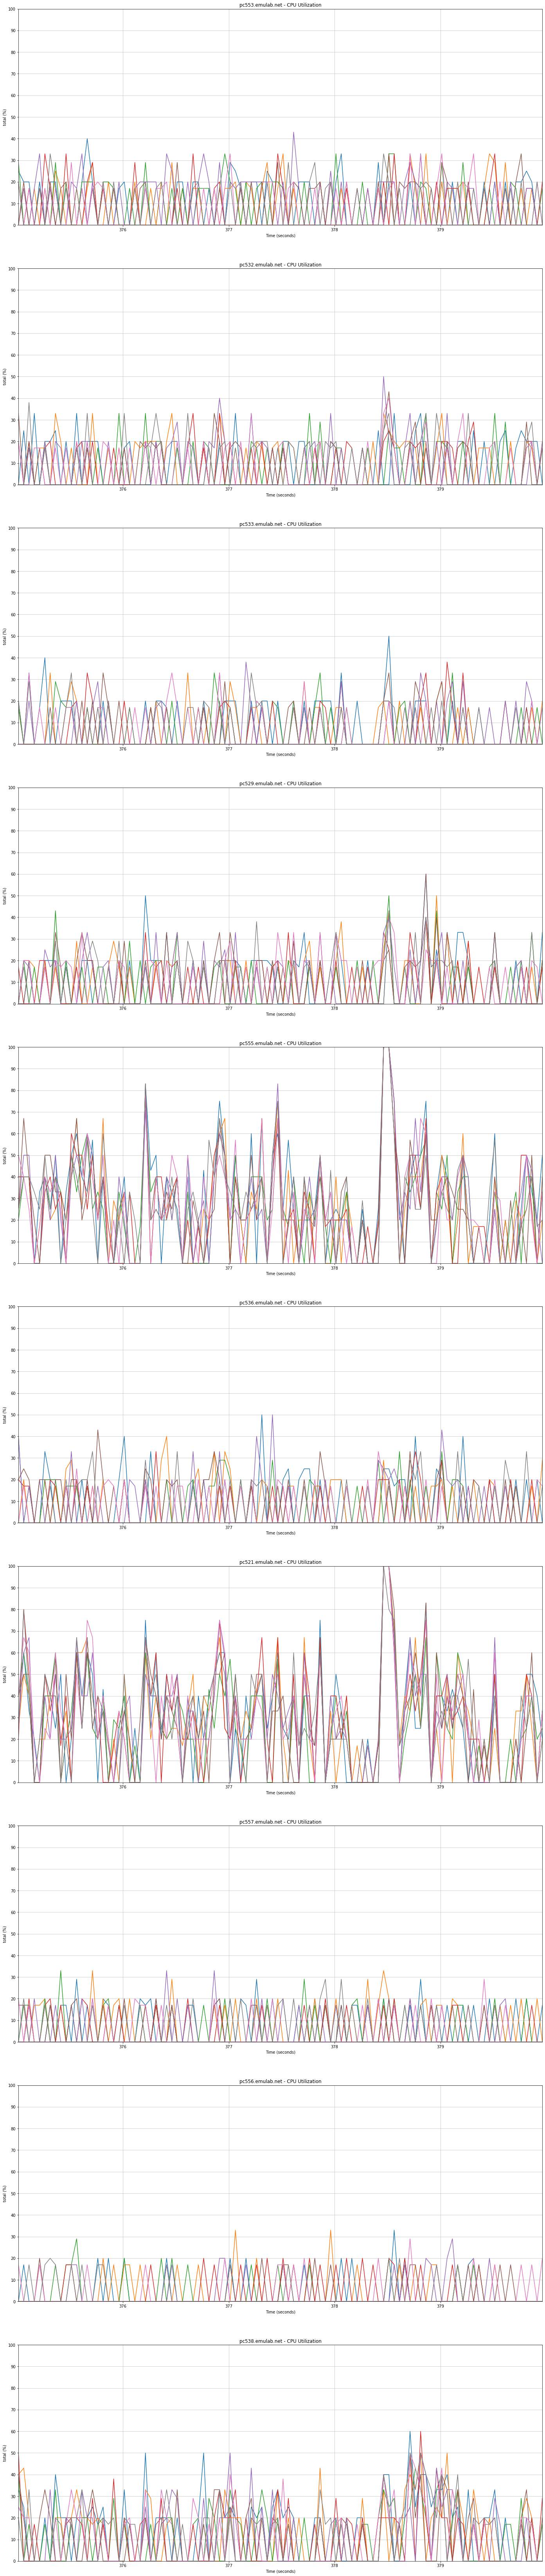

In [14]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = 375
# Maximum time (in seconds)
MAX_TIME = 380

# Plot CPU utilization
fig = plt.figure(figsize=(24, len(node_names) * 12))
for (i, node_name) in enumerate(node_names):
    df = cpu[(cpu["node_name"] == node_name)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    if df.empty:
        continue
    df = df.groupby(["timestamp", "hw_no"])["value"].mean()
    df = df.unstack()
    ax = fig.add_subplot(len(node_names), 1, i + 1)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, 100))
    ax.grid(alpha=0.75)
    print(node_name)
    print(df.mean())
    df.plot(ax=ax, kind="line", title="%s - CPU Utilization" % node_name, xlabel="Time (seconds)",
            ylabel="%s (%%)" % COLLECTL_CPU_METRIC, grid=True, legend=False, yticks=range(0, 101, 10))

## Memory Monitoring

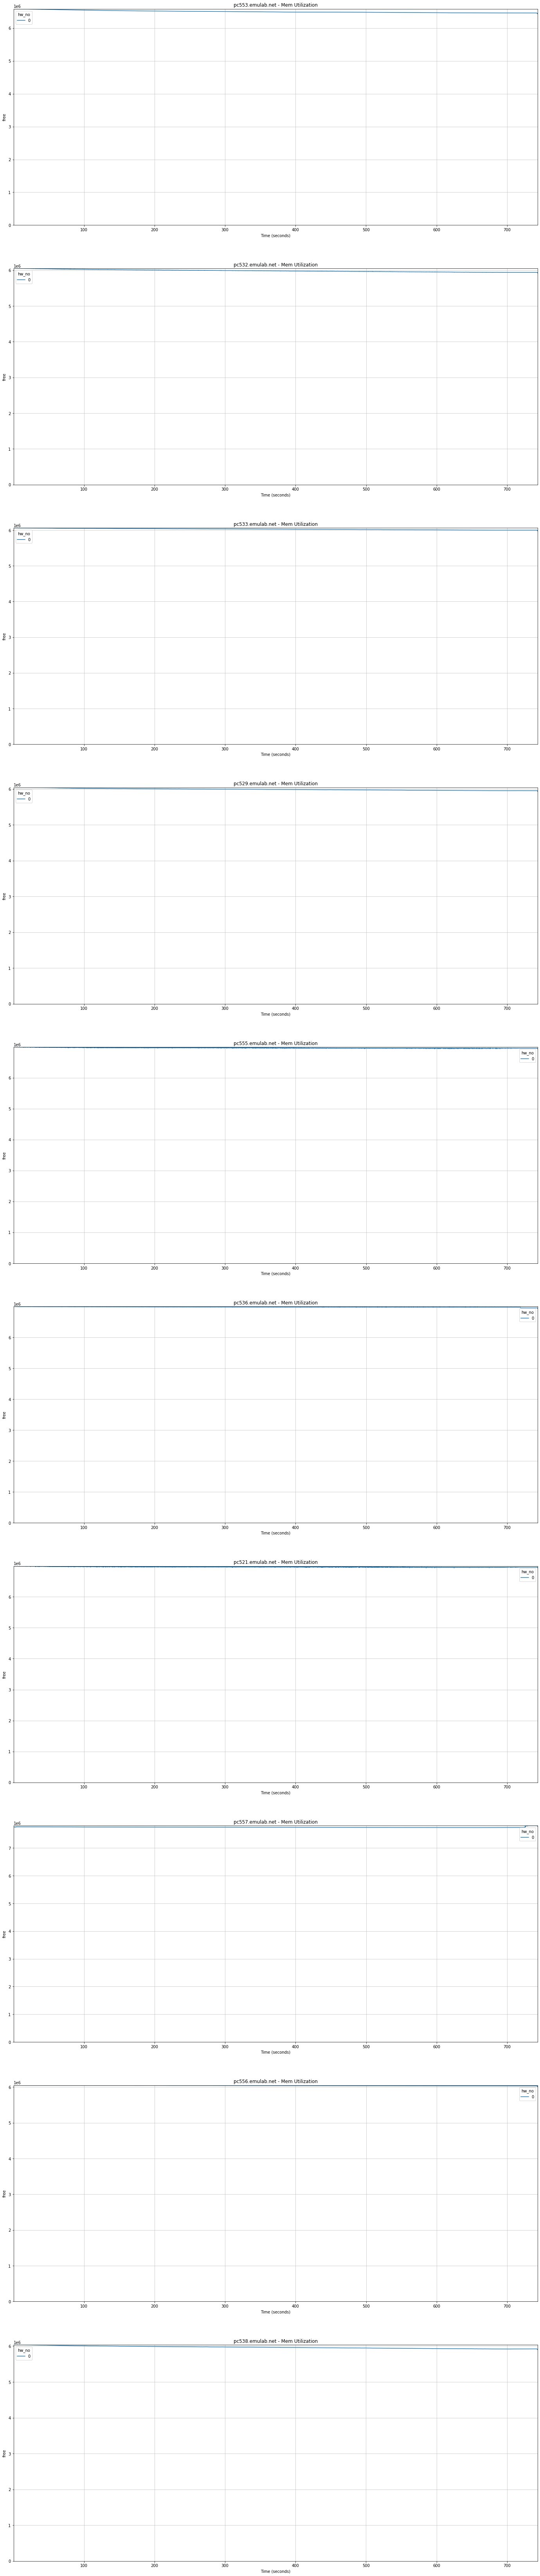

In [9]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot memory utilization
fig = plt.figure(figsize=(24, len(node_names) * 12))
for (i, node_name) in enumerate(node_names):
    df = mem[(mem["node_name"] == node_name)]
    if MIN_TIME:
        df = df[(df["timestamp"] >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df["timestamp"] <= MAX_TIME)]
    df = df.groupby(["timestamp", "hw_no"])["value"].mean()
    df = df.unstack()
    ax = fig.add_subplot(len(node_names), 1, i + 1)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.grid(alpha=0.75)
    df.plot(ax=ax, kind="line", title="%s - Mem Utilization" % node_name, xlabel="Time (seconds)",
            ylabel="%s" % COLLECTL_MEM_METRIC, grid=True)

## Disk Monitoring

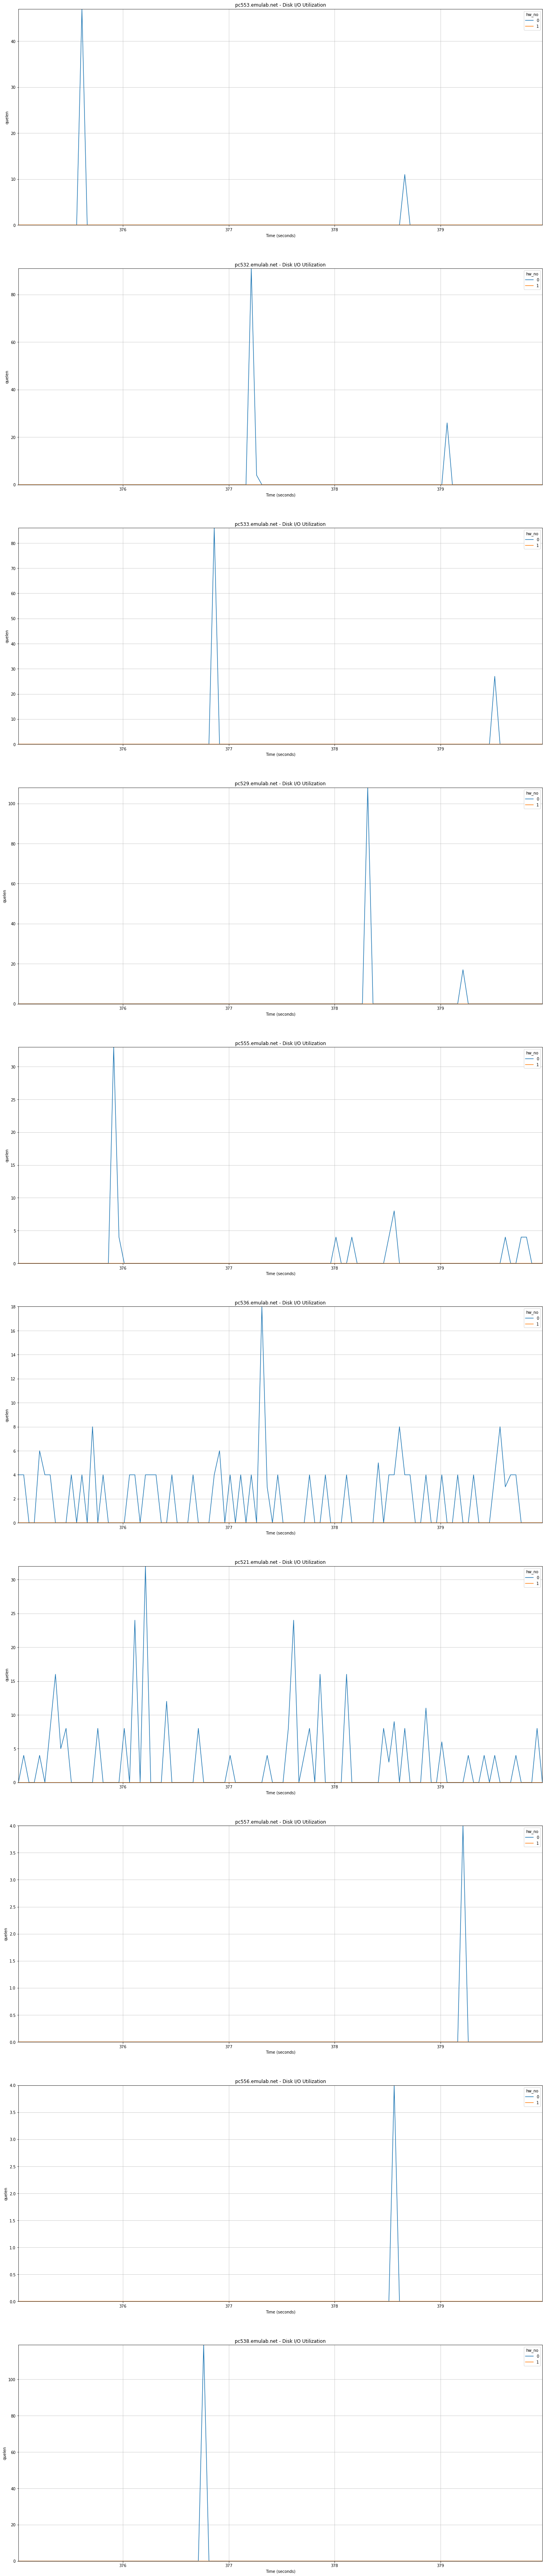

In [16]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = 375
# Maximum time (in seconds)
MAX_TIME = 380

# Plot disk I/O utilization
fig = plt.figure(figsize=(24, len(node_names) * 12))
for (i, node_name) in enumerate(node_names):
    df = dsk[(dsk["node_name"] == node_name)]
    if MIN_TIME:
        df = df[(df.index >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df.index <= MAX_TIME)]
    df = df.groupby(["timestamp", "hw_no"])["value"].mean()
    df = df.unstack()
    ax = fig.add_subplot(len(node_names), 1, i + 1)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.grid(alpha=0.75)
    df.plot(ax=ax, kind="line", title="%s - Disk I/O Utilization" % node_name, xlabel="Time (seconds)",
            ylabel="%s" % COLLECTL_DSK_METRIC, grid=True)